Ref tutorial 
https://ithelp.ithome.com.tw/articles/10241800


In [ ]:
# !pip uninstall matplotlib

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import backtrader as bt
import backtrader.feeds as btfeeds

In [2]:
spy = yf.Ticker("SPY")

In [3]:
hist = spy.history(period="max")

In [4]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-01-29,25.566152,25.566152,25.438957,25.547981,1003200,0.0,0
1993-02-01,25.566156,25.729692,25.566156,25.729692,480500,0.0,0
1993-02-02,25.711514,25.802368,25.657002,25.784197,201300,0.0,0
1993-02-03,25.820542,26.074931,25.802371,26.056761,529400,0.0,0
1993-02-04,26.147601,26.220284,25.856870,26.165771,531500,0.0,0


In [7]:
# get the open and close price in spy
close_price = hist["Close"]
open_price  = hist["Open"]
open2019 = open_price.loc['2019']

In [12]:
# open_price
# open2019

In [13]:
# calculating movering average
import talib
ma5 = talib.SMA(close_price, timeperiod=5)
ma10 = talib.SMA(close_price, timeperiod=10)

In [17]:
# ma10.head(10)

(array([17897., 17956., 18017., 18078., 18140., 18201., 18262.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

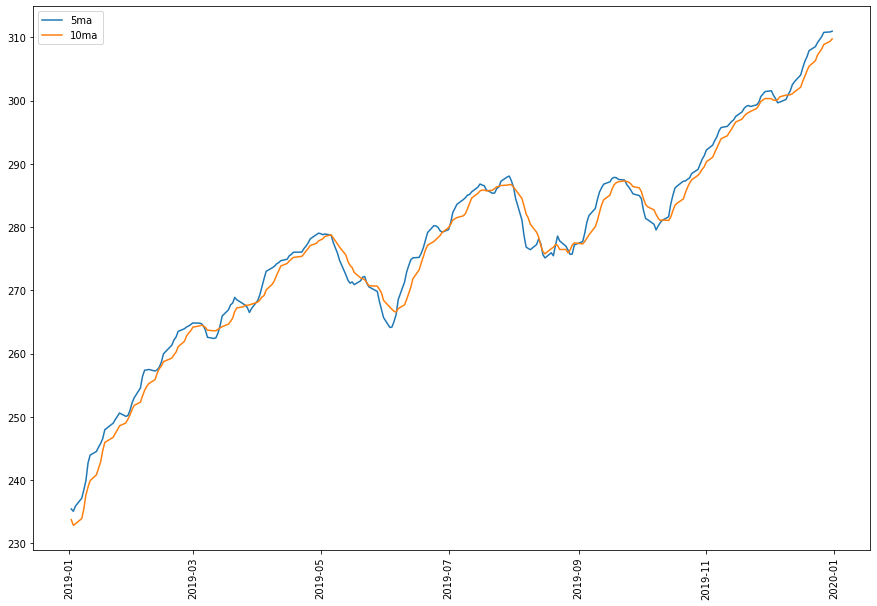

In [18]:
# ploting
plt.figure(figsize=(15,10))
plt.plot(ma5['2019'])
plt.plot(ma10['2019'])
plt.legend(['5ma','10ma'])
plt.xticks(rotation='vertical')

In [20]:
# difference between 5ma and 10ma
# 當5日均線向上穿越10日均線的時候買進，當5日均線向下穿越10日均線的時候賣出。
MA_dif = ma5 - ma10
MA_dif = MA_dif['2019']

# parameter
stock = 0
sig = [] 

# 訊號
for i in range(len(MA_dif)):
    # 5MA往上穿越10MA
    if MA_dif[i-1] < 0 and MA_dif[i] > 0 and stock == 0:
        stock += 1
        sig.append(1)
    
    # 5MA往下穿越10MA
    elif MA_dif[i-1] > 0 and MA_dif[i] < 0 and stock == 1:
        stock -= 1
        sig.append(-1)
    else:
        sig.append(0)

# 製作dataframe
import pandas as pd
ma_sig = pd.Series(index = MA_dif.index, data = sig)
ma_sig_2019 = ma_sig['2019']

In [21]:
ma_sig_2019.to_excel("spy ma trade.xlsx")

In [22]:
# 每次買賣的報酬率
rets = []
transaction = []

# 是否仍有庫存
stock = 0
stock_his = []

# 當次交易買入價格
buy_price = 0

# 當次交易賣出價格
sell_price = 0

# 每次買賣的報酬率
for i in range(len(ma_sig_2019)-1):
    stock_his.append(stock)
    if ma_sig_2019[i] == 1:
        # 隔日開盤買入
        buy_price = open2019[ma_sig_2019.index[i+1]]
        stock += 1
        # 紀錄交易日期
        transaction.append([ma_sig_2019.index[i+1],'buy'])
    elif ma_sig_2019[i] == -1:
        # 隔日開盤賣出
        sell_price = open2019[ma_sig_2019.index[i+1]]
        stock -= 1
        rets.append((sell_price-buy_price)/buy_price)
        # 賣出後就清空資料
        buy_price = 0
        sell_price = 0
        # 紀錄交易日期
        transaction.append([ma_sig_2019.index[i+1],'sell'])

# 如果最後手上有庫存，就用回測區間最後一天的開盤價賣掉
if stock == 1 and buy_price != 0 and sell_price == 0:
    sell_price = open2019[-1]
    rets.append((sell_price-buy_price)/buy_price)
    stock -= 1
    transaction.append([open2019.index[-1],'sell'])

# 總報酬率
total_ret = 1
for ret in rets:
    total_ret *= 1 + ret
# print(str(round((total_ret - 1)*100,2)) + '%')
print('總報酬率：' + str(round(100*(total_ret-1),2)) + '%')
pd.DataFrame(transaction)

總報酬率：12.72%


,0,1
0,2019-03-15,buy
1,2019-03-27,sell
2,2019-04-02,buy
3,2019-05-07,sell
4,2019-05-22,buy
5,2019-05-24,sell
6,2019-06-10,buy
7,2019-07-02,sell
8,2019-07-03,buy
9,2019-07-23,sell


In [25]:
rets

[0.0020317162112225766,
 0.014368568129638258,
 -0.005990663792950729,
 0.026532470471309126,
 0.006595380085096128,
 -0.026599894916648534,
 0.005616352379692211,
 0.0027500947637748158,
 0.014282027948294855,
 0.05728698275705219,
 0.025716992031538898]

In [26]:
import os
import sys
import math

In [27]:
import datetime
import backtrader as bt
import backtrader.feeds as btfeeds

In [28]:
# datapath = os.path.join(modpath, 'orcl-1995-2014.txt')

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname='orcl-1995-2014.txt',
    # Do not pass values before this date
    fromdate=datetime.datetime(2000, 1, 1),
    # Do not pass values after this date
    todate=datetime.datetime(2000, 12, 31),
    reverse=False)

In [31]:
data

In [35]:
# import data from pandas dataframe
# Create a Data Feed
# data = bt.feeds.PandasData(dataname=hist)

In [36]:
# data

In [44]:
# sma cross strategy
class SmaCross(bt.Strategy):
    # 交易紀錄
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    # 設定交易參數
    params = dict(
        ma_period_short=5,
        ma_period_long=10
    )

    def __init__(self):
        # 均線交叉策略
        sma1 = bt.ind.SMA(period=self.p.ma_period_short)
        sma2 = bt.ind.SMA(period=self.p.ma_period_long)
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        
        # 使用自訂的sizer函數，將帳上的錢all-in
        self.setsizer(sizer())
        
        # 用開盤價做交易
        self.dataopen = self.datas[0].open

    def next(self):
        # 帳戶沒有部位
        if not self.position:
            # 5ma往上穿越20ma
            if self.crossover > 0:
                # 印出買賣日期與價位
#                 self.log('BUY ' + ', Price: ' + str(self.dataopen[0]))
                print(self.dataopen)
                # 使用開盤價買入標的
                self.buy(price=self.dataopen[0])
        # 5ma往下穿越20ma
        elif self.crossover < 0:
            # 印出買賣日期與價位
#             self.log('SELL ' + ', Price: ' + str(self.dataopen[0]))
            # 使用開盤價賣出標的
            self.close(price=self.dataopen[0])

# 計算交易部位
class sizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            return math.floor(cash/data[1])
        else:
            return self.broker.getposition(data)

In [45]:
# 初始化cerebro
cerebro = bt.Cerebro()
# feed data
cerebro.adddata(data)
# add strategy
cerebro.addstrategy(SmaCross)
# run backtest
cerebro.run()

In [ ]:
# pip install matplotlib

<IPython.core.display.Javascript object>


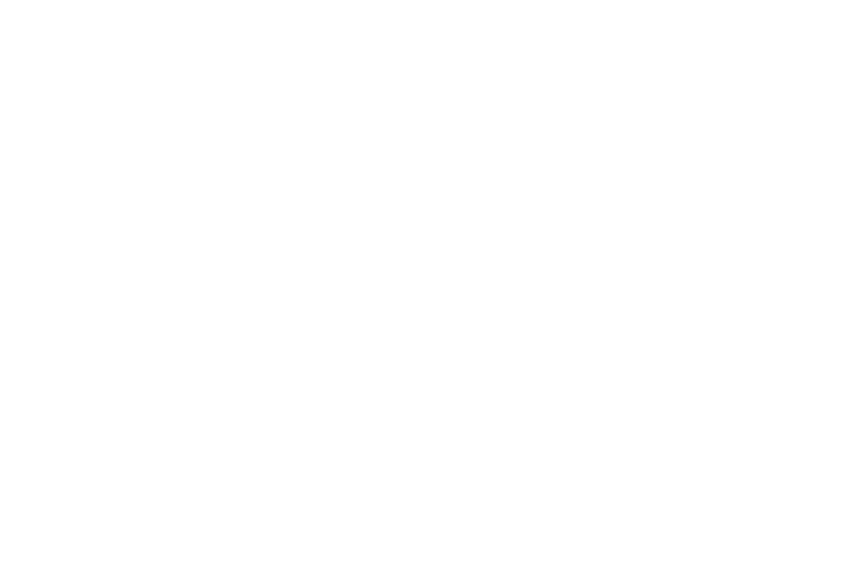

[[<Figure size 432x288 with 5 Axes>]]

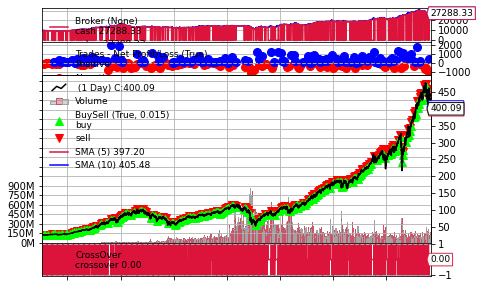

In [39]:
# plot diagram
cerebro.plot()

In [41]:
import matplotlib
print(matplotlib.__version__)

3.5.2
